In [22]:
from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import sequence
import simplejson as json
import tensorflow as tf
import pandas as pd
import os
from tensorflow.keras import layers

from keras.utils.vis_utils import plot_model
from keras import metrics
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Dropout, Embedding, concatenate
from keras.utils.vis_utils import plot_model
from google.cloud import storage
from google.cloud.storage import Blob

client = storage.Client(project="ds5500")

bucket = client.get_bucket("kkbox-data")

#INPUT_PATH = "D:\\Northeastern\\100 pct undersample split\\"
INPUT_PATH = "gs://kkbox-data/data_100_pct_undersample/"

# Load Data

In [2]:
# Load from GCS
temp_path = "/tmp/train_user_logs_padded.npy"
blob = Blob("data_100_pct_undersample/train_user_logs_padded.npy", bucket)
with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)

In [3]:
X_user_logs = np.load(temp_path)
print(X_user_logs.shape)
print(X_user_logs[0][0][0:10])

(24798, 762, 7)
[2.43421435e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.15294003e-06]


In [4]:
X_members = pd.read_csv(INPUT_PATH + "X_train_transformed.csv").sort_values("msno").drop(["msno"],axis=1).values
y = pd.read_csv(INPUT_PATH + "y_train.csv", header=None).sort_values(0).drop([0],axis=1).values

In [5]:
num_members_cols = X_members.shape[1]
num_members_cols

27

# User Logs and Member Data (LSTM)

In [20]:
batch_size = 128
epochs = 5
lstm_units = 16

num_members = X_user_logs.shape[0]
num_dates = X_user_logs.shape[1]
num_user_log_cols = X_user_logs.shape[2]
num_member_cols = X_members.shape[1]

data_in_a = Input(shape = (num_dates,num_user_log_cols))
a = LSTM(lstm_units)(data_in_a)
a_mod = Model(data_in_a, outputs=a)

data_in_b = Input(shape = (num_member_cols,))
b = Dense(16, activation='relu')(data_in_b)
b_mod = Model(data_in_b, outputs=b)

combined = concatenate([a_mod.output, b_mod.output])
c = Dense(1, activation='softmax')(combined)

model = Model(inputs=[a_mod.input, b_mod.input], outputs=c)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

#model.summary()
model.fit([X_user_logs, X_members], y, batch_size=batch_size, epochs=epochs,verbose=1,use_multiprocessing=True)


Epoch 1/5
24798/24798 [==============================] - 75s 3ms/step - loss: 7.6481 - accuracy: 0.5012
Epoch 2/5
24798/24798 [==============================] - 72s 3ms/step - loss: 7.6481 - accuracy: 0.5012
Epoch 3/5
24798/24798 [==============================] - 72s 3ms/step - loss: 7.6481 - accuracy: 0.5012
Epoch 4/5
24798/24798 [==============================] - 73s 3ms/step - loss: 7.6481 - accuracy: 0.5012
Epoch 5/5
24798/24798 [==============================] - 74s 3ms/step - loss: 7.6481 - accuracy: 0.5012


# Member data only

In [33]:
batch_size = 128

epochs = 10
features = X_members.shape[1]

data_in = Input(shape = (features,))
x = Dense(1, activation='softmax')(data_in)
model = Model(inputs=data_in, outputs=x)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = [metrics.binary_accuracy])
model.summary()
model.fit(X_members, y, batch_size=batch_size, epochs=epochs,verbose=0)

print("number of predictions = 1 out of {} observations: {}".format(X_members.shape[0],model.predict(X_members).sum()))
# output is: number of predictions = 1 out of 24798 observations: 24798

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 27)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 28        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________
number of predictions = 1 out of 24798 observations: 24798.0


In [34]:
pd.DataFrame(X_members)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.895605,1.0,0.0,0.566010,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.036206,1.0,0.0,-0.944241,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.036206,0.0,0.0,-1.046130,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.083950,1.0,0.0,0.889772,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.870938,0.0,1.0,-0.256724,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24793,0.991094,0.0,0.0,1.985799,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24794,0.322672,1.0,0.0,-1.000423,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24795,0.131695,1.0,0.0,-0.029139,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24796,0.227183,1.0,0.0,2.239095,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


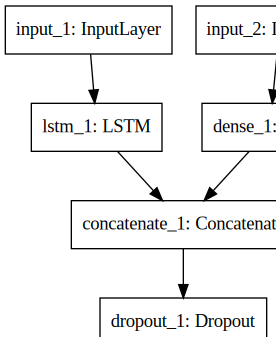

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))